In [1]:
# set up non-QM hardware
import Labber
# connect to server 
client = Labber.connectToServer('localhost') # get list of instruments 
#instruments = client.getListOfInstrumentsString() 
#for instr in instruments: 
#    print(instr) # close connection 

# reset all QDevil channels to 0 V
QDevil = client.connectToInstrument('QDevil QDAC', dict(interface='Serial', address='3'))
for n in range(24):
    if n+1 < 10:
        QDevil.setValue("CH0" + str(n+1) + " Voltage", 0.0)
    else:
        QDevil.setValue("CH" + str(n+1) + " Voltage", 0.0)
# setting CH01 to sweet spot
DC_ss = -0.158888
QDevil.setValue("CH01 Voltage", DC_ss)

# Set other qubits at the antinode
QDevil.setValue("CH02 Voltage", 0.6)
QDevil.setValue("CH03 Voltage", 2.9)
QDevil.setValue("CH04 Voltage", 3.4)

# digital attenuators
Vaunix1 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25606'))
Vaunix2 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25607'))
ROI = 32
ROO = 10
Vaunix1.setValue("Attenuation", ROI)
Vaunix2.setValue("Attenuation", ROO)

# TWPA pump
SG = client.connectToInstrument('Rohde&Schwarz RF Source', dict(interface='TCPIP', address='192.168.88.2'))
freq_TWPA = 6326E6;
pwr_TWPA = -10;
SG.setValue('Frequency', freq_TWPA)
SG.setValue('Power', pwr_TWPA)

client.close()

In [2]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from configuration import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
import qdac as qdac
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from qutip import *
import datetime 
import os
import time
import warnings

warnings.filterwarnings("ignore")


qubit_index = 0 # for UA Q1

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")

tPath = os.path.join(r'Z:\LabberData_DF5\QM_Data_DF5',year,month,'Data_'+month+day)
if not os.path.exists(tPath):
   os.makedirs(tPath)

2023-09-06 08:09:23,307 - qm - INFO     - Starting session: f5e64434-c692-4744-b6ed-f15fac324743


## No baking



In [4]:
now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'Zdelay'
qubit_name = 'UA_Q1'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

# The QUA program #
n_avg = 2_000
cooldown_time = 5_000 # ns, set in wait() function
taus = np.arange(4, 152 + 0.1, 1) # Z delay 
qubit_index = 0 
dc = 0.5

with program() as zdelay:
    n = declare(int)
    n_st = declare_stream()
    t = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(t, taus)):
            align()
            wait(25, machine.qubits[qubit_index].name, machine.flux_lines[qubit_index].name,
                 machine.resonators[qubit_index].name)
            
            wait(t, machine.flux_lines[qubit_index].name) # when inside the for loop, t has a delay of an extra 16 ns
            set_dc_offset(machine.flux_lines[qubit_index].name, "single", dc)
            wait(300 * u.ns, machine.flux_lines[qubit_index].name)
            set_dc_offset(machine.flux_lines[qubit_index].name, "single", machine.flux_lines[qubit_index].max_frequency_point)
            wait(280 * u.ns, machine.qubits[qubit_index].name) 
            # Need to add 100 ns instead of 120 ns because there seems to be a delay of 20 ns between flux line and XY pulse (is it initial tau?)
            play("cw" * amp(0.9), machine.qubits[qubit_index].name, duration = 80*u.ns )
            
            wait(152 - t,machine.qubits[qubit_index].name, machine.flux_lines[qubit_index].name )
            align()
            measure(
                "readout",
                machine.resonators[qubit_index].name,
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
    
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time, machine.resonators[qubit_index].name)

        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(taus)).average().save("I")
        Q_st.buffer(len(taus)).average().save("Q")
        n_st.save("iteration")

#  Open Communication with the QOP  #
qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)

simulate = False
if simulate:
    simulation_config = SimulationConfig(duration=4000)  # in clock cycles
    job = qmm.simulate(config, zdelay, simulation_config)
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(zdelay)
    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    # Live plotting, with pop-up window
    %matplotlib qt
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
        Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
        # Progress bar
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        # Plot results
        plt.cla()
        plt.title("Z delay")
        plt.plot(taus *4.0 *u.ns, np.sqrt(I**2 + Q**2))
        plt.xlabel("Z delay [ns]")
        plt.ylabel("signal [V]")
        plt.pause(0.01)

2023-09-06 08:11:06,246 - qm - ERROR    - Encountered connection error from QOP
Traceback (most recent call last):
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\base_api.py", line 27, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\frontend_api.py", line 79, in get_version
    response = run_async(self._stub.get_version(Empty(), timeout=self._timeout))
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\utils\async_utils.py", line 37, in run_async
    return create_future(coroutine).result()  # type: ignore[no-any-return]
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 444, in result
    return self.__get_result()
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 389, in __get_result
    raise self._exception
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\

ERROR:qm.api.base_api:Encountered connection error from QOP
Traceback (most recent call last):
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\base_api.py", line 27, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\frontend_api.py", line 79, in get_version
    response = run_async(self._stub.get_version(Empty(), timeout=self._timeout))
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\utils\async_utils.py", line 37, in run_async
    return create_future(coroutine).result()  # type: ignore[no-any-return]
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 444, in result
    return self.__get_result()
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 389, in __get_result
    raise self._exception
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\grpc\frontend\__i

2023-09-06 08:11:06,345 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-09-06 08:11:06,355 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-09-06 08:11:07,027 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-09-06 08:11:07,247 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Execution stopped by user!                                   ] 8.1% (n=161/2000) --> elapsed time: 11.14s


Text(0, 0.5, '$\\sqrt{I^2 + Q^2}$ [V]')

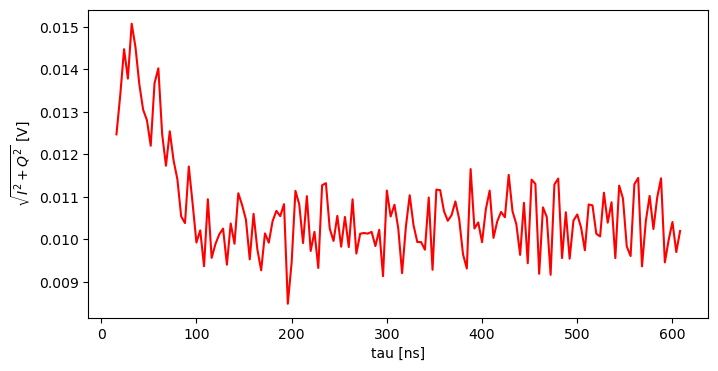

In [8]:
I, Q, iteration = results.fetch_all()
I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
sigs = np.sqrt(I**2 + Q**2)
phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))

%matplotlib inline
fig = plt.figure(figsize=[8, 4])
plt.plot(taus * 4, sigs, 'r')
plt.xlabel("tau [ns]")
plt.ylabel("$\sqrt{I^2 + Q^2}$ [V]")

In [ ]:
savemat(os.path.join(tPath, file_name), {"tau": taus, "sig": sigs, "sig_phase": phase, "DC_flux": DC_ss, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

## With baking


In [28]:
now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'Zdelay'
qubit_name = 'UA_Q1'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

qubit_index = 0 
n_avg = 50_000
cooldown_time = 20_000 # set in wait() function
dt = 1
sample_rate = round(1 / dt * 1e9)

def baked_pulse_wait(wait_duration):
    # define 1ns interval for waiting of the flux line and play a cw pulse with amp and duration defined in the config file
    wait_segments = []
    t_vec = np.arange(0, wait_duration, dt) 
    for i in range(wait_duration):
        with baking(config, sampling_rate=sample_rate, padding_method="left") as b:
            b.wait(round(t_vec[i]* (sample_rate / 1e9)), machine.flux_lines[qubit_index].name)
            b.play("const", machine.flux_lines[qubit_index].name)
            b.wait(round((np.max(t_vec)+dt - t_vec[i]) * (sample_rate / 1e9)), machine.flux_lines[qubit_index].name)
        wait_segments.append(b)
    return wait_segments
       
# The QUA program #
dc = 0.5
wait_duration = 4 # to do the fine meshing of the wait time in the baking (a number too large would overflow the buffer)
qubit_wait = 600//4 # 600 ns when defined
seq_duration = 1100//4 # in c.c. # this is the duration of the total experiment
wait_segments_list = baked_pulse_wait(wait_duration)
delay_sweep = np.arange(4 * 4, seq_duration * 4, 1) - qubit_wait * 4 # delay sweep range

# the last 4 is to account for the initial wait of the flux line
res_wait = (seq_duration*wait_duration)//4 + machine.flux_lines[qubit_index].flux_pulse_length//4 +4
with program() as zdelay_baked:
    n = declare(int)
    n_st = declare_stream()
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    tau = declare(int)

    with for_(n, 0, n < n_avg, n + 1):
        with for_(tau, 4, tau < seq_duration, tau+1): 
            for i in range(0, wait_duration):
                wait(25, machine.qubits[qubit_index].name, machine.flux_lines[qubit_index].name, 
                    machine.resonators[qubit_index].name ) # wait initial 100 ns (units of clock cycle)
                # XY
                wait(qubit_wait, machine.qubits[qubit_index].name)
                play("cw" * amp(0.9), machine.qubits[qubit_index].name, duration = 344*u.ns )
                # Z
                wait(tau, machine.flux_lines[qubit_index].name)
                wait_segments_list[i].run() 
                wait(seq_duration-tau,machine.flux_lines[qubit_index].name)
                align()
                measure(
                    "readout",
                    machine.resonators[qubit_index].name,
                    None,
                    dual_demod.full("rotated_cos", "out1", "rotated_sin", "out2", I),
                    dual_demod.full("rotated_minus_sin", "out1", "rotated_cos", "out2", Q),
                )
                save(I, I_st)
                save(Q, Q_st)
                wait(cooldown_time*u.ns)
                
        save(n, n_st)

    with stream_processing():
        I_st.buffer((seq_duration-4)*wait_duration).average().save("I")
        Q_st.buffer((seq_duration-4)*wait_duration).average().save("Q")
        n_st.save("iteration")

#  Open Communication with the QOP  #
qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)

simulate = False
if simulate:
    simulation_config = SimulationConfig(duration=4_000)  # in clock cycles
    job = qmm.simulate(config, zdelay_baked, simulation_config)
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(zdelay_baked)
    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    %matplotlib qt
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
        Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
        # Progress bar
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("Z delay")
        plt.plot(delay_sweep, np.sqrt(I**2 + Q**2))
        plt.xlabel("Z delay [ns]")
        plt.ylabel("signal [V]")
        plt.pause(0.01)

2023-09-06 09:06:25,151 - qm - ERROR    - Encountered connection error from QOP
Traceback (most recent call last):
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\base_api.py", line 27, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\frontend_api.py", line 79, in get_version
    response = run_async(self._stub.get_version(Empty(), timeout=self._timeout))
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\utils\async_utils.py", line 37, in run_async
    return create_future(coroutine).result()  # type: ignore[no-any-return]
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 444, in result
    return self.__get_result()
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 389, in __get_result
    raise self._exception
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\

ERROR:qm.api.base_api:Encountered connection error from QOP
Traceback (most recent call last):
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\base_api.py", line 27, in wrapped
    return func(*args, **kwargs)
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\api\frontend_api.py", line 79, in get_version
    response = run_async(self._stub.get_version(Empty(), timeout=self._timeout))
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\utils\async_utils.py", line 37, in run_async
    return create_future(coroutine).result()  # type: ignore[no-any-return]
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 444, in result
    return self.__get_result()
  File "C:\Users\painter\.conda\envs\labber-qm-env\lib\concurrent\futures\_base.py", line 389, in __get_result
    raise self._exception
  File "C:\Users\painter\AppData\Roaming\Python\Python38\site-packages\qm\grpc\frontend\__i

2023-09-06 09:06:25,240 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-09-06 09:06:25,250 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-09-06 09:06:26,435 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-09-06 09:06:26,843 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Progress: [##################################################] 100.0% (n=50000/50000) --> elapsed time: 1183.54s
Progress: [##################################################] 100.0% (n=50000/50000) --> elapsed time: 1183.67s
Execution stopped by user!


Text(0, 0.5, 'signal [V]')

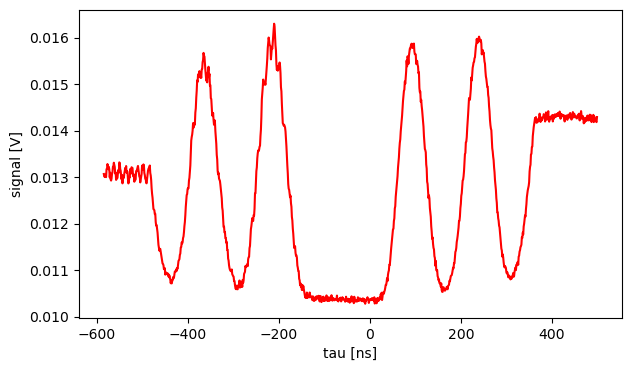

In [29]:
I, Q, iteration = results.fetch_all()
I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
sig_amp = np.sqrt(I**2 + Q**2)
sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))

%matplotlib inline
fig = plt.figure(figsize=[7, 4])
plt.plot(delay_sweep, sig_amp, 'r')
plt.xlabel("tau [ns]")
plt.ylabel("signal [V]")

In [ ]:
#machine.flux_lines[qubit_index].flux_pulse_amp = 0.3
#machine.flux_lines[qubit_index].flux_pulse_length = 500
machine._save("quam_state.json")

In [30]:
savemat(os.path.join(tPath, file_name), {"delay_sweep": delay_sweep, "sig_amp": sig_amp, "sig_phase": sig_phase, "DC_flux": DC_ss, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)